# Uniswap Demo

## Introduction to Uniswap

>"Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction."

## Model File structure
* lab_notebook.ipynb
* model

There are a parts folder and 4 files in model folder: [config.py](model/config.py), which contains the simulation configurations, aggregating the partial states and the state variables; [partial_state_update_block.py](model/partial_state_update_block.py), which contains the partial state update blocks and how they update the state variables; [state_variables.py](state_variables.py), which defines the model's state variables and [run.py](model/run.py), which runs the simulation.

The components of the model are found in the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)
* [uniswap_events.pickle](https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange)

The initial parameters and hyperparameters of the system are defined in [sys_params.py](model/sys_params.py) and helper functions, plots, etc. are in [utils.py](model/parts/utils.py).

### Unzip data

In [1]:
# unzip data file
from zipfile import ZipFile 
import os
  
# loading the temp.zip and creating a zip object 
with ZipFile(os.getcwd() + "/data/uniswap_events.pickle.zip", 'r') as zObject: 
  
    # Extracting specific file in the zip 
    # into a specific location. 
    zObject.extract( 
        "uniswap_events.pickle", path=os.getcwd() + "/data") 
zObject.close() 

## Run Model

In [2]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))## Model File structure

# 16/Jul/2024 20:14

In [3]:
%%capture
# %matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
from model import run
from model.sys_params import sys_params
from model.state_variables import genesis_states
from model.partial_state_update_block import PSUBs
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

In [4]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: multi_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 177199, 6, 8, 4)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (177199, 6, 8, 4)


Initializing configurations:   0%|          | 0/8 [00:00<?, ?it/s]

Execution Method: parallelize_simulations
Execution Mode: parallelized


Flattening results:   0%|          | 0/8 [00:00<?, ?it/s]

Total execution time: 75.23s
Execution in 76.5s


In [5]:
fees = [(1-(param/1000))*100 for param in sys_params['fee_numerator']]
retail_tols = [param*100 for param in sys_params['retail_tolerance']]
retail_precision = [param for param in sys_params['retail_precision']]

## Analysis

For information on how to access and analysis data from the ETH/DAI Uniswap smart contract, visit our sister notebook [here](Uniswap_EthDai_Exchange_Data.ipynb).


In this section, we will analyze how well our model compares to the actual data.

In [6]:
model_history = experiments[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [7]:
UNI_df = pd.read_pickle('./data/uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

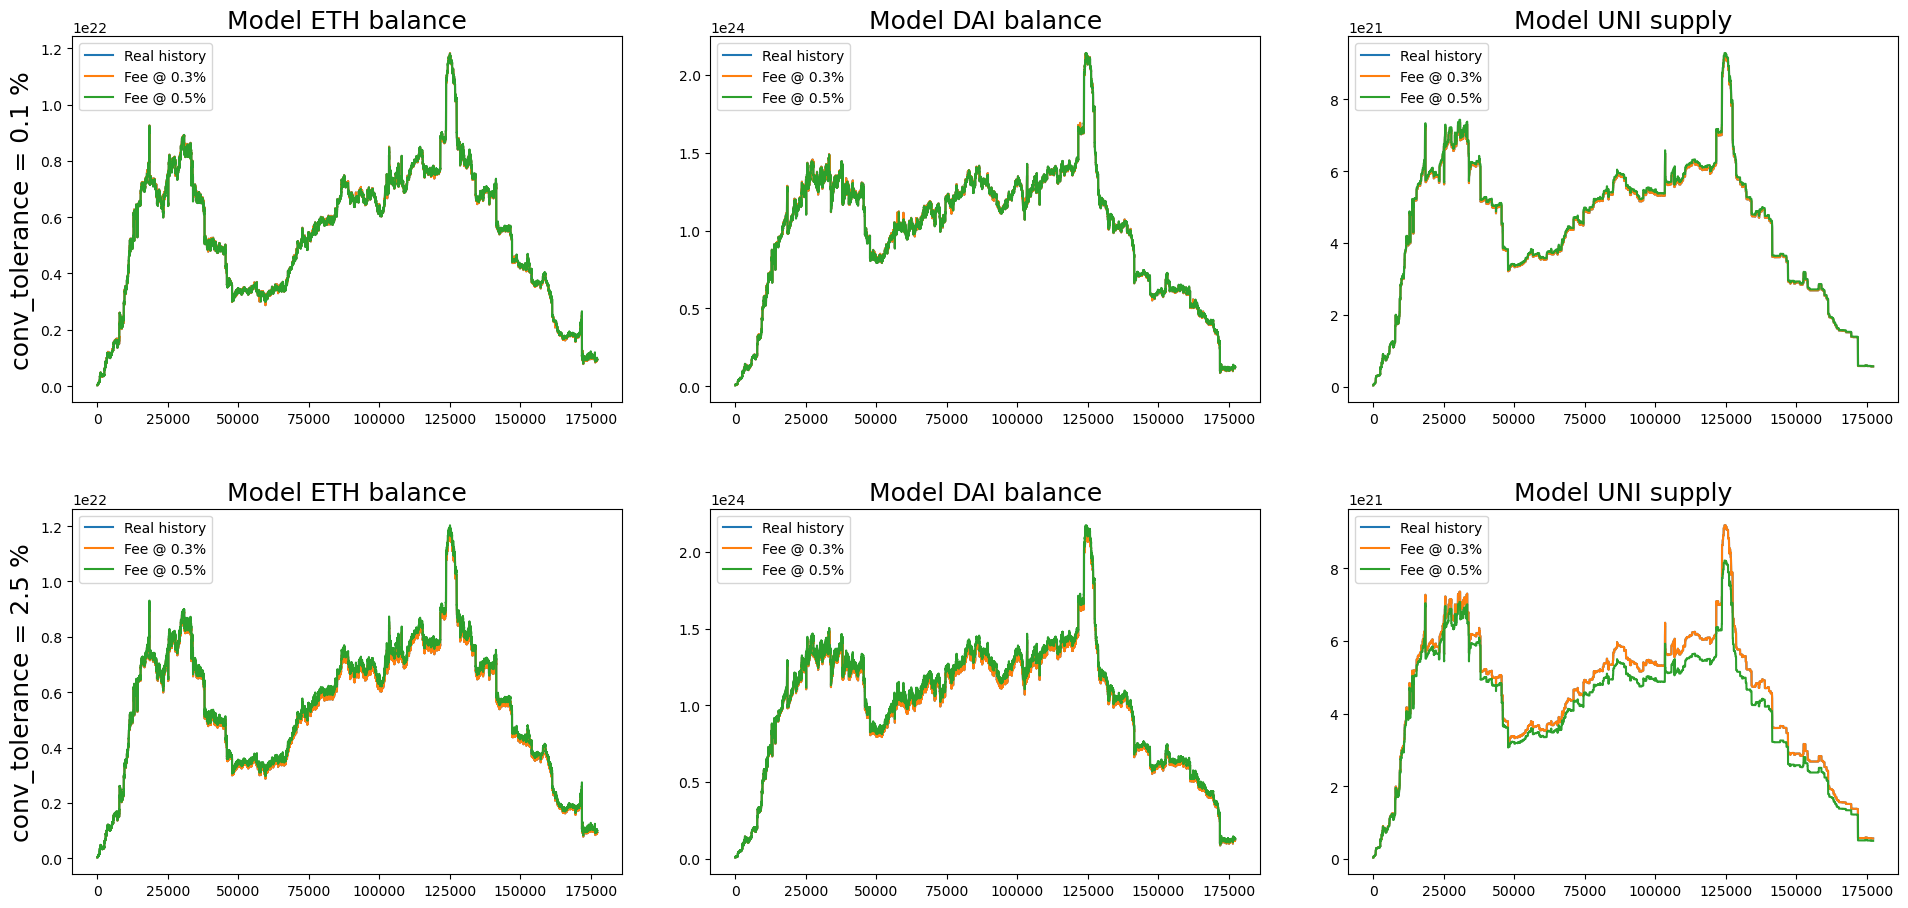

In [8]:
models = list()
for i in experiments['subset'].unique():
    models.append(experiments.loc[experiments['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply']])
    
for df in models:
    df.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']
    df.reset_index(inplace=True)


nplots = len(set(fees))
nrows = len(set(retail_tols))
ncols = 3

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(20,10))

plt.close()

for i in range(nrows):
    axs[i][0].plot(real_history['real_ETH_balance'], label='Real history')
    axs[i][1].plot(real_history['real_DAI_balance'], label='Real history')
    axs[i][2].plot(real_history['real_UNI_supply'], label='Real history')
    axs[i][0].set_title('Model ETH balance', fontsize=18)
    axs[i][1].set_title('Model DAI balance', fontsize=18)
    axs[i][2].set_title('Model UNI supply', fontsize=18)
    axs[i][0].set_ylabel('conv_tolerance = {:.1f} %'.format(retail_tols[i]), fontsize=18)
    
    for k in range(nplots):
        axs[i][0].plot(models[nplots*nrows*k + i]['model_ETH_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][1].plot(models[nplots*nrows*k + i]['model_DAI_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][2].plot(models[nplots*nrows*k + i]['model_UNI_supply'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))

    for j in range(ncols):
        axs[i][j].legend(loc='upper left')

fig.tight_layout(pad=4.0)
fig

Despite the simplifications, the outputs of the model are very similar to real data.

In [13]:
df = experiments

prev_dai = pd.concat([pd.Series([np.nan]),df['DAI_balance'][:-1]]).reset_index(drop=True)
prev_eth = pd.concat([pd.Series([np.nan]),df['ETH_balance'][:-1]]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'].diff()
df['delta_eth'] = df['ETH_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])

The success of Uniswap is directly associated to how much liquidity is being provided to the model. However, modelling the liquidity provider agent is a difficult task, as its decision making process tends to be very complex. Therefore, analyzing how much return a liquidity provider would have in Uniswap can be a more effective strategy, since higher returns mean more attractiveness for liquidity providers. To understand how a fee modification impacts the returns of the liquidity provider, we will use the following script:

In [14]:
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

plot_data = experiments.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

a = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)

This script returns a dataframe containing the historic return of three different strategies: **50/50 hodler**, **ETH hodler** and **UNI hodler** (liquidity provider). With these data, it is possible to use cadCAD's parameter sweeping feature to validate hypotheses according to possible scenarios for Uniswap. The parameters swept are described below:
- **retail_precision**: This model assumes two classes of users: arbitrageurs and retail traders. Swaps observed in the historical data will be replayed against the model or not depending on the state of the model and individual policies implemented for each one of the user classes. Therefore, swaps must be classified as originating from one of the two classes of users. We apply a simple heuristic based on the precision of the values involved in the trade. If either the precision of the input or the output of a swap are less than or equal to `retail_precision`, the swap is classified as a retail trade. For example, let's consider a swap with an eth_delta of `-0.005542280351005221` (precision 18) and a token_delta of `1.529800000000000000` (precision 4). 
  * If `retail_precision >= 4`, then this swap would be classified as a retail trade
  * If `retail_precision < 4`, then this swap would be classified as an arbitrage - in other words, we assume this swap is too precise for it to be plausible it would have been executed by a retail trader on the Uniswap UI, and therefore must have originated from an arbitrageur

- **retail_tolerance**: In order for swaps observed in the historical data that are classified as retail trades to be replayed against the model, the effective price paid by the simulated agent must not be higher than the price observed in the historical data, factored by the `retail_tolerance` parameter. In other words, this determines the retail trader's tolerance (in %) to receive less money from an exchange made. For example, if in a certain exchange in Uniswap's real history **1 ETH** was sold for **250 DAI** and retail_tolerance is set at **0.05**, the model will replay the trade (sell 1 ETH) if given the state of the model the trader receives **237.5 DAI or more** for it. Otherwise, the trade will be disregarded in the simulation.

Now, let's plot the calculated returns to analyze the sensitivity of the model to the parameters. The following script shows the plots dynamically as the number of parameters changes. The simulation made used two fee (**0.3% and 0.5%**), two retail_tolerance (**0.05% and 2.5%**) and two retail_precision (**3 and 15**) values.

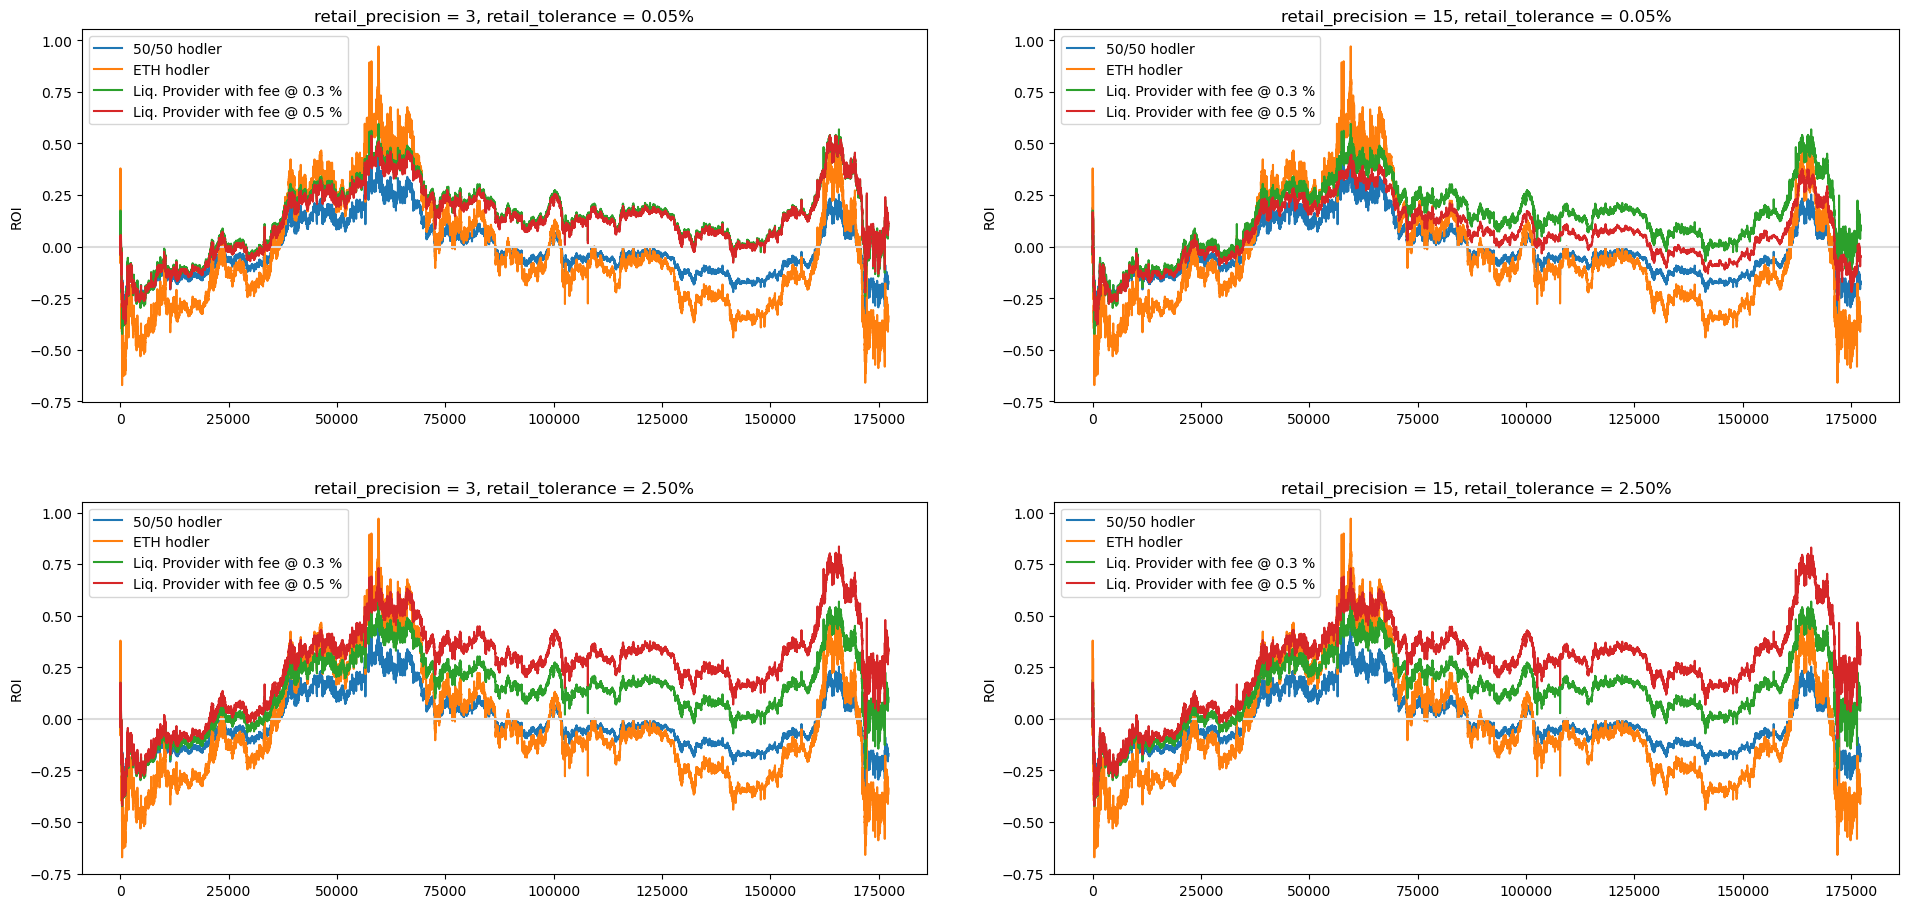

In [15]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(set(fees))
nrows = len(set(retail_tols))
ncols = len(set(retail_precision))

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(ncols*10,nrows*5))

plt.close()

if nrows > 1:
    for i in range(nrows):
        if ncols > 1:
            for j in range(ncols):
                axs[i][j].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
                axs[i][j].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
                axs[i][j].axhline(0, color='gainsboro')
                axs[i][j].set_title(f'retail_precision = {retail_precision[ncols*j]}, retail_tolerance = {retail_tols[i]/100:.2%}')
                axs[i][j].set_ylabel('ROI')
                for k in range(nplots):
                    ema = ExpMovingAverage(plots[nplots*nrows*k + ncols*j + i]['UNI_hodler_return'], 1)
                    axs[i][j].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nplots*nrows*k + ncols*j + i]))
            for j in range(ncols):
                axs[i][j].legend(loc='upper left')

fig.set_facecolor('white')
fig.tight_layout(pad=4.0)
fig

As expected, higher retail tolerance values lead to higher returns for higher fee values, since more retail trades will be allowed. Similarly, lower retail precision values lead to higher returns, as more trades are considered arbitrage and the behavior of this agent causes the pool to always be brought to the "ideal" state. However, it's noticeable that this increase is more significant for lower retail tolerance values.

Another important note is that higher fee values don't necessarily result in higher returns, as shown by the plot in the second column of the first row. This happens because, with low retail tolerance and a high number of retail trades, less of these trades are considered profitable. Therefore, we can conclude that, given the right system conditions, **higher fees can make Uniswap less attractive to liquidity providers**.

Finally, it's important to state that retail_tolerance and retail_precision are both **arbitrary parameters** over which there is **no control in a real system**, created to possibilitate the development of the agents' behaviors and the trade classification mechanism and, as shown above, to allow hypotheses validation through parameter sweeping.

## Conclusion

In this notebook, we have illustrated how to create a cadCAD model that takes in real data and replicates the mechanics of a real world smart contract extremely acurately by translating the smart contract code into python code. We enforce best practices for cadCAD modeling, and analyze our simulation data against the real data.

As future work proposals, we see that the liquidity provider behavior can be better explored and its return can be analyzed further. A good way to do that is to represent the retail tolerance parameter as a probability distribution. In this way, Monte Carlo runs can be used to create stochastic analysis.

Besides that, when usingt he arbitrage trader profit function, the model shows results that differ from Uniswap historical data. Because of that, this behavior wasn't taken into account for the return results shown before, and further analyses on this agent's behavior might help to increase its accuracy.